### IMPORTS

In [1]:
# manipulate data
import numpy as np
import pandas as pd

# statistical tests
import scipy as sp

# visualize data
import matplotlib.pyplot as plt
import seaborn as sn

# model preparation
from sklearn.model_selection import (train_test_split, learning_curve,
                                     LearningCurveDisplay, validation_curve,
                                     ValidationCurveDisplay)
from sklearn.preprocessing import StandardScaler

# pytorch
import torch as pt

# machine learning models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# model evaluation
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                            RocCurveDisplay, accuracy_score, f1_score,
                            precision_score, recall_score)

np.random.seed(123)
pd.options.display.max_columns = 100

### Load and Preprocess: Cardiovascular Disease

In [2]:
file1 = "cardio_data_processed.csv"
cardio_vasc = pd.read_csv(file1)

In [3]:
# id: just an index
# useing age_years over age
# using weight and height instead of bmi
# using ap_hi/lo instead of bp_category and bp_category_encoded
cardio_cols_drop = ['id', 'age', 'bmi', 'bp_category',
                    'bp_category_encoded', "alco", "smoke",
                    'gender', 'gluc', 'active', 'cholesterol']
cardio_vasc = cardio_vasc.drop(columns=cardio_cols_drop, axis=1)

In [4]:
cardio_vasc = cardio_vasc.sample(frac=0.15)

In [5]:
cardio_vasc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10231 entries, 12148 to 67751
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   height     10231 non-null  int64  
 1   weight     10231 non-null  float64
 2   ap_hi      10231 non-null  int64  
 3   ap_lo      10231 non-null  int64  
 4   cardio     10231 non-null  int64  
 5   age_years  10231 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 559.5 KB


In [6]:
cardio_vasc.head(3)

,height,weight,ap_hi,ap_lo,cardio,age_years
12148,173,70.0,110,70,0,43
5541,168,75.0,120,80,1,51
40053,158,85.0,140,80,1,64


In [7]:
cardio_vasc['cardio'].value_counts() / len(cardio_vasc['cardio'])

cardio
0    0.510898
1    0.489102
Name: count, dtype: float64

In [8]:
# split data
cd_train, cd_test = train_test_split(cardio_vasc, test_size=.15,
                                     random_state=123, stratify=cardio_vasc['cardio'])

# get X, y
target_col = "cardio"
cols_drop = ["cardio"]
X_train_cd = cd_train.drop(cols_drop, axis=1)
X_test_cd = cd_test.drop(cols_drop, axis=1)
y_train_cd = cd_train[target_col]
y_test_cd = cd_test[target_col]

scale = StandardScaler()
scale.fit(X_train_cd)
X_train_scaled_cd = pd.DataFrame(data=scale.transform(X_train_cd),
                                 columns=X_train_cd.columns,
                                 index=X_train_cd.index)
X_test_scaled_cd = pd.DataFrame(data=scale.transform(X_test_cd),
                                columns=X_test_cd.columns,
                                index=X_test_cd.index)

### Baseline: Cardiovascular Disease

In [9]:
# calculat a baseline
act_pred_error_cd = pd.DataFrame({"actual": y_train_cd})
act_pred_error_cd["baseline_prediction"] = y_train_cd.value_counts().index[0]

baseline_acc_cd = accuracy_score(act_pred_error_cd["actual"], act_pred_error_cd["baseline_prediction"])

# print baseline accuracy
print(f"Baseline Accuracy Score: {round(baseline_acc_cd, 2)}%")

Baseline Accuracy Score: 0.51%


### Run Model: Cardiovascular Disease
#### Learning/Validation Curve: Cardiovascular Disease

In [10]:
# create dictionary for each model
class_modelsCD = {'decision tree':{'model': DecisionTreeClassifier(random_state=123)},
                  'knn':{'model': KNeighborsClassifier(n_jobs=-1)},
                  'gradient boosting':{'model': GradientBoostingClassifier(random_state=123)},
                  'support vector machine': {'model': SVC(random_state=123,
                                                          kernel='rbf')},
                  'mlp':{'model': MLPClassifier(random_state=123)}}

In [11]:
cd_params = {'decision tree': {'param1_name': 'min_samples_split', 
                               'param1_range':  [2, 4, 6, 8, 10],
                               'param2_name':'max_depth',
                               'param2_range': [5, 10, 15, 20]},
             'knn': {'param1_name': 'n_neighbors',
                     'param1_range': [3, 5, 7, 9],
                     'param2_name': 'leaf_size',
                     'param2_range': [20, 30, 40, 50]},
             'gradient boosting': {'param1_name': 'n_estimators',
                                   'param1_range': [50, 100, 150, 200],
                                   'param2_name': 'subsample',
                                   'param2_range': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             'support vector machine': {'param1_name': 'C',
                                        'param1_range': [0.5, 0.75, 1.0, 1.5, 2.0],
                                        'param2_name': 'gamma',
                                        'param2_range': np.logspace(-6, -1, 5)},
             'mlp': {'param1_name': 'max_iter',
                     'param1_range': [100, 150, 200],
                     'param2_name': 'hidden_layer_sizes',
                     'param2_range': [50, 75, 100, 125, 150]}}

In [ ]:
for model_name in class_modelsCD.keys():
    print(f'Working on: {model_name}')
    
    estimator = class_modelsCD[model_name]['model']

    VCparam_name1cd = cd_params[model_name]['param1_name']
    VCparam_range1cd = cd_params[model_name]['param1_range']
    VCparam_name2cd = cd_params[model_name]['param2_name']
    VCparam_range2cd = cd_params[model_name]['param2_range']

    # learning curve
    print(f'Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)')
    fittedLCcd = learning_curve(estimator=estimator,
                                  X=X_train_cd,
                                  y=y_train_cd,
                                  train_sizes=[0.7, 0.75, 0.80, 0.90],
                                  cv=4,
                                  scoring='accuracy',
                                  n_jobs=-1,
                                  random_state=123,
                                  return_times=True)

    # validation curves
    print(f'Fitting VC: Hyper 1 ({VCparam_name1cd}, {VCparam_range1cd})')
    fittedVC_param1cd = validation_curve(estimator=estimator,
                                       X=X_train_cd,
                                       y=y_train_cd,
                                       param_name=VCparam_name1cd,
                                       param_range=VCparam_range1cd,
                                       cv=4,
                                       scoring='accuracy',
                                       n_jobs=-1,)

    print(f'Fitting VC: Hyper 2 ({VCparam_name2cd}, {VCparam_range2cd})\n')
    fittedVC_param2cd = validation_curve(estimator=estimator,
                                       X=X_train_cd,
                                       y=y_train_cd,
                                       param_name=VCparam_name2cd,
                                       param_range=VCparam_range2cd,
                                       cv=4,
                                       scoring='accuracy',
                                       n_jobs=-1,)
    
    LCtrain_sizescd, LCtrain_scorescd, LCtest_scorescd, fit_times, score_times = fittedLCcd
    VCtrain_scores1cd, VCtest_scores1cd = fittedVC_param1cd
    VCtrain_scores2cd, VCtest_scores2cd = fittedVC_param2cd

    # learning curve to dict
    class_modelsCD[model_name]['LCtrain_sizescd'] = LCtrain_sizescd
    class_modelsCD[model_name]['LCtrain_scorescd'] = LCtrain_scorescd
    class_modelsCD[model_name]['LCtest_scorescd'] = LCtest_scorescd

    # param1 vc to dict
    class_modelsCD[model_name]['VCtrain_scores1cd'] = VCtrain_scores1cd
    class_modelsCD[model_name]['VCtest_scores1cd'] = VCtest_scores1cd

    # param2 vc to dict
    class_modelsCD[model_name]['VCtrain_scores2cd'] = VCtrain_scores2cd
    class_modelsCD[model_name]['VCtest_scores2cd'] = VCtest_scores2cd

### Visualize Model LC and VC: Cardiovascular Disease

In [ ]:
for model_name in class_modelsCD.keys():
    print(f'Working on: {model_name}')

    LCtrain_sizes = class_modelsCD[model_name]['LCtrain_sizescd']
    LCtrain_scores = class_modelsCD[model_name]['LCtrain_scorescd']
    LCtest_scores = class_modelsCD[model_name]['LCtest_scorescd']

    VCtrain_scores1 = class_modelsCD[model_name]['VCtrain_scores1cd']
    VCtest_scores1 = class_modelsCD[model_name]['VCtest_scores1cd']

    VCtrain_scores2 = class_modelsCD[model_name]['VCtrain_scores2cd']
    VCtest_scores2 = class_modelsCD[model_name]['VCtest_scores2cd']

    param1_name = cd_params[model_name]['param1_name']
    param1_range = cd_params[model_name]['param1_range']

    param2_name = cd_params[model_name]['param2_name']
    param2_range = cd_params[model_name]['param2_range']    

    LCdisplay = LearningCurveDisplay(train_sizes=LCtrain_sizes,
                                   train_scores=LCtrain_scores,
                                   test_scores=LCtest_scores,
                                   score_name="accuracy")

    VCdisplay1 = ValidationCurveDisplay(param_name=param1_name,
                                        param_range=param1_range,
                                        train_scores=VCtrain_scores1,
                                        test_scores=VCtest_scores1,
                                        score_name="accuracy")

    VCdisplay2 = ValidationCurveDisplay(param_name=param2_name,
                                        param_range=param2_range,
                                        train_scores=VCtrain_scores2,
                                        test_scores=VCtest_scores2,
                                        score_name="accuracy")
    print(f'LC ({model_name})')
    LCdisplay.plot()
    
    print(f'VC: Hyper 1 ({param1_name})')
    VCdisplay1.plot()
    
    print(f'VC: Hyper 2 ({param2_name})')
    VCdisplay2.plot()

    plt.show()

$$
\textbf{CARDIOVASCULAR DISEASE}\\~\\
\textbf{TESTING START}\\
\textbf{TESTING START}\\
\textbf{TESTING START}\\
$$

In [42]:
hyper_cd = {'support vector machine': {'param1_name': 'C',
                                        'param1_range': [0.5, 0.75, 1.0, 1.5, 2.0],
                                        'param2_name': 'gamma',
                                        'param2_range': np.logspace(-6, -1, 5)},
             'mlp': {'param1_name': 'batch_size',
                     'param1_range': [25, 50, 75, 100, 125],
                     'param2_name': 'hidden_layer_sizes',
                     'param2_range': [50, 75, 100, 125, 150]}}

model_cd = {'support vector machine': {'model': SVC(random_state=123,
                                                    kernel='poly',
                                                    degree=2)},
            'mlp':{'model': MLPClassifier(random_state=123,
                                          learning_rate_init=0.01,
                                          max_iter=300,
                                          solver='adam')}}

$$
\textbf{SVM}\\
\textbf{SVM}\\
\textbf{SVM}
$$

In [44]:
model_name = 'support vector machine'

print(f'Working on: {model_name}')

estimator = model_cd[model_name]['model']

VCparam_name1cd = hyper_cd[model_name]['param1_name']
VCparam_range1cd = hyper_cd[model_name]['param1_range']
VCparam_name2cd = hyper_cd[model_name]['param2_name']
VCparam_range2cd = hyper_cd[model_name]['param2_range']

# learning curve
print(f'Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)')
fittedLCcd = learning_curve(estimator=estimator,
                                X=X_train_cd,
                                y=y_train_cd,
                                train_sizes=[0.7, 0.75, 0.80, 0.90],
                                cv=4,
                                scoring='accuracy',
                                n_jobs=-1,
                                random_state=123,
                                return_times=True)

# validation curves
print(f'Fitting VC: Hyper 1 ({VCparam_name1cd}, {VCparam_range1cd})')
fittedVC_param1cd = validation_curve(estimator=estimator,
                                    X=X_train_cd,
                                    y=y_train_cd,
                                    param_name=VCparam_name1cd,
                                    param_range=VCparam_range1cd,
                                    cv=4,
                                    scoring='accuracy',
                                    n_jobs=-1,)

print(f'Fitting VC: Hyper 2 ({VCparam_name2cd}, {VCparam_range2cd})\n')
fittedVC_param2cd = validation_curve(estimator=estimator,
                                    X=X_train_cd,
                                    y=y_train_cd,
                                    param_name=VCparam_name2cd,
                                    param_range=VCparam_range2cd,
                                    cv=4,
                                    scoring='accuracy',
                                    n_jobs=-1,)

LCtrain_sizescd, LCtrain_scorescd, LCtest_scorescd, fit_times, score_times = fittedLCcd
VCtrain_scores1cd, VCtest_scores1cd = fittedVC_param1cd
VCtrain_scores2cd, VCtest_scores2cd = fittedVC_param2cd

# learning curve to dict
model_cd[model_name]['LCtrain_sizescd'] = LCtrain_sizescd
model_cd[model_name]['LCtrain_scorescd'] = LCtrain_scorescd
model_cd[model_name]['LCtest_scorescd'] = LCtest_scorescd

# param1 vc to dict
model_cd[model_name]['VCtrain_scores1cd'] = VCtrain_scores1cd
model_cd[model_name]['VCtest_scores1cd'] = VCtest_scores1cd

# param2 vc to dict
model_cd[model_name]['VCtrain_scores2cd'] = VCtrain_scores2cd
model_cd[model_name]['VCtest_scores2cd'] = VCtest_scores2cd


Working on: support vector machine
Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)


Fitting VC: Hyper 1 (C, [0.5, 0.75, 1.0, 1.5, 2.0])
Fitting VC: Hyper 2 (gamma, [1.00000000e-06 1.77827941e-05 3.16227766e-04 5.62341325e-03
 1.00000000e-01])



Working on: support vector machine
LC (support vector machine)
VC: Hyper 1 (C)
VC: Hyper 2 (gamma)


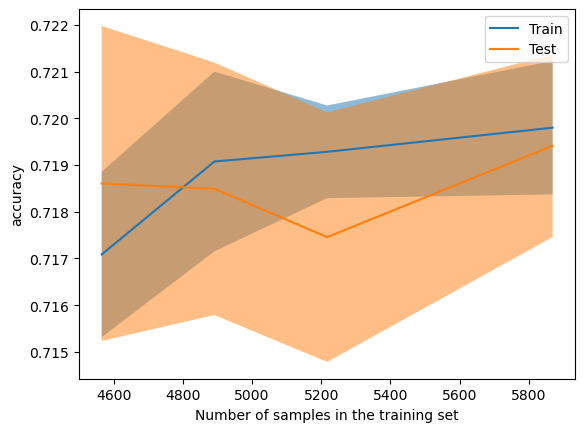

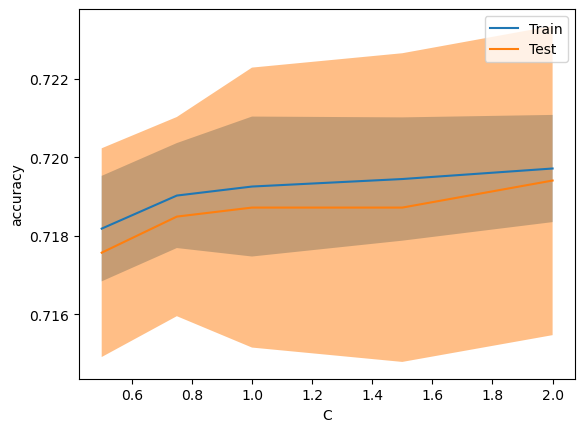

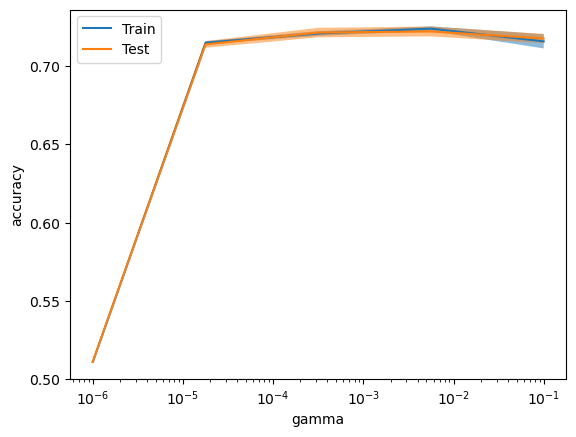

In [45]:
model_name = 'support vector machine'
print(f'Working on: {model_name}')

LCtrain_sizes = model_cd[model_name]['LCtrain_sizescd']
LCtrain_scores = model_cd[model_name]['LCtrain_scorescd']
LCtest_scores = model_cd[model_name]['LCtest_scorescd']

VCtrain_scores1 = model_cd[model_name]['VCtrain_scores1cd']
VCtest_scores1 = model_cd[model_name]['VCtest_scores1cd']

VCtrain_scores2 = model_cd[model_name]['VCtrain_scores2cd']
VCtest_scores2 = model_cd[model_name]['VCtest_scores2cd']

param1_name = hyper_cd[model_name]['param1_name']
param1_range = hyper_cd[model_name]['param1_range']

param2_name = hyper_cd[model_name]['param2_name']
param2_range = hyper_cd[model_name]['param2_range']    

LCdisplay = LearningCurveDisplay(train_sizes=LCtrain_sizes,
                                train_scores=LCtrain_scores,
                                test_scores=LCtest_scores,
                                score_name="accuracy")

VCdisplay1 = ValidationCurveDisplay(param_name=param1_name,
                                    param_range=param1_range,
                                    train_scores=VCtrain_scores1,
                                    test_scores=VCtest_scores1,
                                    score_name="accuracy")

VCdisplay2 = ValidationCurveDisplay(param_name=param2_name,
                                    param_range=param2_range,
                                    train_scores=VCtrain_scores2,
                                    test_scores=VCtest_scores2,
                                    score_name="accuracy")
print(f'LC ({model_name})')
LCdisplay.plot()

print(f'VC: Hyper 1 ({param1_name})')
VCdisplay1.plot()

print(f'VC: Hyper 2 ({param2_name})')
VCdisplay2.plot()

plt.show()

$$
\textbf{MLP}\\
\textbf{MLP}\\
\textbf{MLP}
$$

In [46]:
model_name = 'mlp'

print(f'Working on: {model_name}')

estimator = model_cd[model_name]['model']

VCparam_name1cd = hyper_cd[model_name]['param1_name']
VCparam_range1cd = hyper_cd[model_name]['param1_range']
VCparam_name2cd = hyper_cd[model_name]['param2_name']
VCparam_range2cd = hyper_cd[model_name]['param2_range']

# learning curve
print(f'Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)')
fittedLCcd = learning_curve(estimator=estimator,
                                X=X_train_cd,
                                y=y_train_cd,
                                train_sizes=[0.7, 0.75, 0.80, 0.90],
                                cv=4,
                                scoring='accuracy',
                                n_jobs=-1,
                                random_state=123,
                                return_times=True)

# validation curves
print(f'Fitting VC: Hyper 1 ({VCparam_name1cd}, {VCparam_range1cd})')
fittedVC_param1cd = validation_curve(estimator=estimator,
                                    X=X_train_cd,
                                    y=y_train_cd,
                                    param_name=VCparam_name1cd,
                                    param_range=VCparam_range1cd,
                                    cv=4,
                                    scoring='accuracy',
                                    n_jobs=-1,)

print(f'Fitting VC: Hyper 2 ({VCparam_name2cd}, {VCparam_range2cd})\n')
fittedVC_param2cd = validation_curve(estimator=estimator,
                                    X=X_train_cd,
                                    y=y_train_cd,
                                    param_name=VCparam_name2cd,
                                    param_range=VCparam_range2cd,
                                    cv=4,
                                    scoring='accuracy',
                                    n_jobs=-1,)

LCtrain_sizescd, LCtrain_scorescd, LCtest_scorescd, fit_times, score_times = fittedLCcd
VCtrain_scores1cd, VCtest_scores1cd = fittedVC_param1cd
VCtrain_scores2cd, VCtest_scores2cd = fittedVC_param2cd

# learning curve to dict
model_cd[model_name]['LCtrain_sizescd'] = LCtrain_sizescd
model_cd[model_name]['LCtrain_scorescd'] = LCtrain_scorescd
model_cd[model_name]['LCtest_scorescd'] = LCtest_scorescd

# param1 vc to dict
model_cd[model_name]['VCtrain_scores1cd'] = VCtrain_scores1cd
model_cd[model_name]['VCtest_scores1cd'] = VCtest_scores1cd

# param2 vc to dict
model_cd[model_name]['VCtrain_scores2cd'] = VCtrain_scores2cd
model_cd[model_name]['VCtest_scores2cd'] = VCtest_scores2cd


Working on: mlp
Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)
Fitting VC: Hyper 1 (batch_size, [25, 50, 75, 100, 125])
Fitting VC: Hyper 2 (hidden_layer_sizes, [50, 75, 100, 125, 150])



Working on: mlp
LC (mlp)
VC: Hyper 1 (batch_size)
VC: Hyper 2 (hidden_layer_sizes)


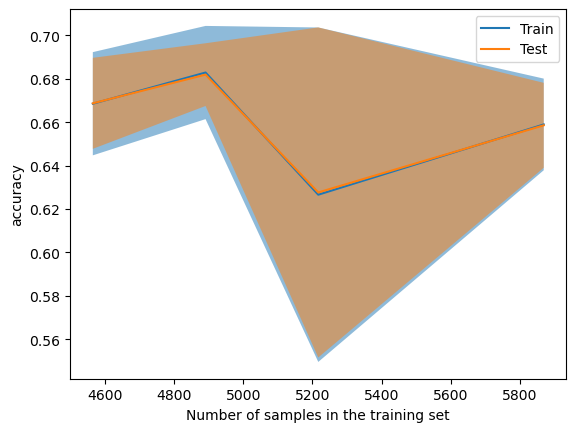

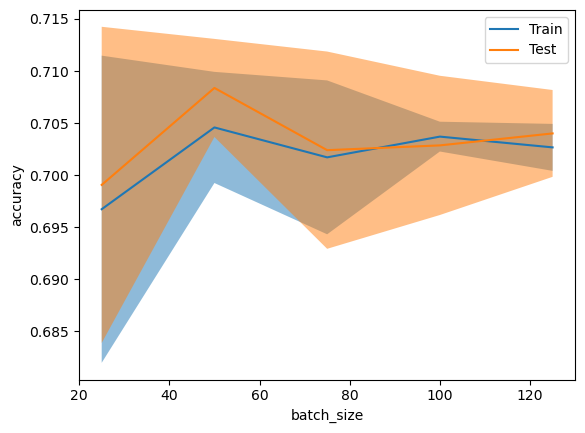

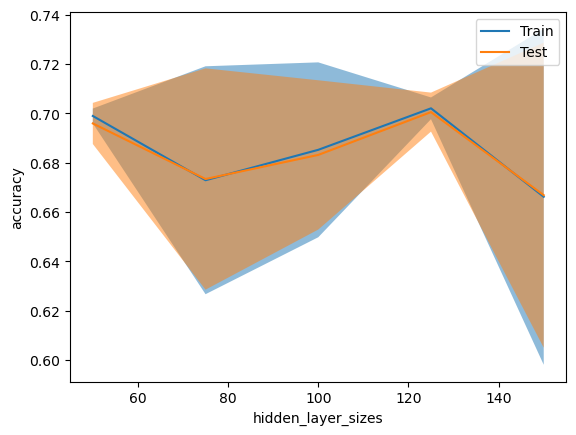

In [47]:
model_name = 'mlp'

print(f'Working on: {model_name}')

LCtrain_sizes = model_cd[model_name]['LCtrain_sizescd']
LCtrain_scores = model_cd[model_name]['LCtrain_scorescd']
LCtest_scores = model_cd[model_name]['LCtest_scorescd']

VCtrain_scores1 = model_cd[model_name]['VCtrain_scores1cd']
VCtest_scores1 = model_cd[model_name]['VCtest_scores1cd']

VCtrain_scores2 = model_cd[model_name]['VCtrain_scores2cd']
VCtest_scores2 = model_cd[model_name]['VCtest_scores2cd']

param1_name = hyper_cd[model_name]['param1_name']
param1_range = hyper_cd[model_name]['param1_range']

param2_name = hyper_cd[model_name]['param2_name']
param2_range = hyper_cd[model_name]['param2_range']    

LCdisplay = LearningCurveDisplay(train_sizes=LCtrain_sizes,
                                train_scores=LCtrain_scores,
                                test_scores=LCtest_scores,
                                score_name="accuracy")

VCdisplay1 = ValidationCurveDisplay(param_name=param1_name,
                                    param_range=param1_range,
                                    train_scores=VCtrain_scores1,
                                    test_scores=VCtest_scores1,
                                    score_name="accuracy")

VCdisplay2 = ValidationCurveDisplay(param_name=param2_name,
                                    param_range=param2_range,
                                    train_scores=VCtrain_scores2,
                                    test_scores=VCtest_scores2,
                                    score_name="accuracy")
print(f'LC ({model_name})')
LCdisplay.plot()

print(f'VC: Hyper 1 ({param1_name})')
VCdisplay1.plot()

print(f'VC: Hyper 2 ({param2_name})')
VCdisplay2.plot()

plt.show()

$$
\textbf{TESTING END}\\
\textbf{TESTING END}\\
\textbf{TESTING END}\\
$$

#### Final Model: Cardiovascular Disease

### Load and Preprocess: Nutrition Facts

In [14]:
file2 = "MyFoodData_Nutrition_Facts_SpreadSheet_Release_1.4.xlsx"
nutrition_facts = pd.read_excel(file2)

In [15]:
nutrition_facts = nutrition_facts.dropna(axis=0, subset=["Food Group"])

# dropping columns that have every value missing
cols_drop = ["Added Sugar g", "Soluble Fiber g", "Insoluble Fiber g",
             "Total sugar alcohols g", "Molybdenum mcg", "Chlorine mg",
             "Biotin B7 mcg", "NetCarbs g"]
nutrition_facts = nutrition_facts.drop(columns=cols_drop, axis=1)

# dropping cols that don't seem to mean much
more_drop = ["PRAL score", "ID", "Name", '183 n3 ccc ALA mg',
             '205 n3 EPA mg', '225 n3 DPA mg', '226 n3 DHA mg',
             "Serving Weight 1 g", "Serving Weight 2 g", "Serving Weight 3 g",
             "Serving Weight 4 g", "Serving Weight 5 g", "Serving Weight 6 g",
             "Serving Weight 7 g", "Serving Weight 8 g", "Serving Weight 9 g",
             "200 Calorie Weight g", "Saturated Fats g",
             "Fat g", "Fiber g", "Calcium mg", "Iron Fe mg", "Potassium K mg", "Magnesium mg",
             "Vitamin A RAE mcg", "Vitamin C mg", "Vitamin B12 mcg", "Vitamin D mcg",
             "Vitamin E AlphaTocopherol mg", "Omega 3s mg", "Omega 6s mg", "Phosphorus P mg",
             "Copper Cu mg", "Thiamin B1 mg", "Riboflavin B2 mg", "Vitamin B6 mg", "Folate B9 mcg",
             "Folic acid mcg", "Food Folate mcg", "Folate DFE mcg", "Choline mg", "Retinol mcg",
             "Carotene beta mcg", "Carotene alpha mcg", "Lycopene mcg", "Lutein + Zeaxanthin mcg",
             "Vitamin K mcg", "Fatty acids total monounsaturated mg", "Fatty acids total polyunsaturated mg",
             "Alcohol g", "Caffeine mg", "Theobromine mg", "Sugars g", "Niacin B3 mg",
             "Selenium Se mcg", "Zinc Zn mg", "Sodium mg"]
nutrition_facts = nutrition_facts.drop(columns=more_drop, axis=1)

# drop column if 70% of its rows are empty
threshold = int(.70*len(nutrition_facts))
nutrition_facts.dropna(axis=1, thresh=threshold, inplace=True)

# drop row if 70% of its columns are empty
threshold = int(.75*len(nutrition_facts.columns))
nutrition_facts.dropna(axis=0, thresh=threshold, inplace=True)

nutrition_facts.fillna(0, inplace=True)

nutrition_facts.columns = nutrition_facts.columns.str.lower()

cols_rename = {"food group": "food_group", "protein g": "protein", "carbohydrate g": "carbohydrate",
                "cholesterol mg": "cholesterol", "water g": "water"}

nutrition_facts = nutrition_facts.rename(mapper=cols_rename, axis=1)

In [16]:
nutrition_facts['food_group'].value_counts() / len(nutrition_facts)

food_group
Meats                      0.227415
Vegetables                 0.162582
Baked Foods                0.066899
Fish                       0.055144
Prepared Meals             0.054360
Fast Foods                 0.049444
Beverages                  0.043246
Baby Foods                 0.038757
Soups and Sauces           0.037903
Sweets                     0.035836
Fruits                     0.032488
Beans and Lentils          0.032132
Breakfast Cereals          0.026788
Dairy and Egg Products     0.026218
Snacks                     0.020732
Dairy and Egg Products     0.019521
Fats and Oils              0.017241
Grains and Pasta           0.016885
Nuts and Seeds             0.012183
American Indian            0.011755
Restaurant Foods           0.007979
Spices and Herbs           0.004488
Name: count, dtype: float64

In [17]:
bool_mask1 = (nutrition_facts['food_group'] == 'Meats') | (nutrition_facts['food_group'] == 'Vegetables') 
bool_mask2 = bool_mask1 | (nutrition_facts['food_group'] == 'Baked Foods')
bool_mask3 = bool_mask2 | (nutrition_facts['food_group'] == 'Fish')
nutrition_facts = nutrition_facts[bool_mask3]

In [18]:
nutrition_facts['food_group'].value_counts() / len(nutrition_facts)

food_group
Meats          0.444135
Vegetables     0.317518
Baked Foods    0.130653
Fish           0.107694
Name: count, dtype: float64

In [19]:
nutrition_facts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7187 entries, 0 to 13869
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   food_group    7187 non-null   object 
 1   calories      7187 non-null   float64
 2   protein       7187 non-null   float64
 3   carbohydrate  7187 non-null   float64
 4   cholesterol   7187 non-null   float64
 5   water         7187 non-null   float64
dtypes: float64(5), object(1)
memory usage: 393.0+ KB


In [20]:
# split data
nf_train, nf_test = train_test_split(nutrition_facts,
                                     test_size=.15,
                                     random_state=123,
                                     stratify=nutrition_facts['food_group'])

# get X, y
target_col = "food_group"
cols_drop = ["food_group"]
X_train_nf = nf_train.drop(cols_drop, axis=1)
X_test_nf = nf_test.drop(cols_drop, axis=1)
y_train_nf = nf_train[target_col]
y_test_nf = nf_test[target_col]

# scale data
scale = StandardScaler()
scale.fit(X_train_nf)
X_train_scaled_nf = pd.DataFrame(data=scale.transform(X_train_nf),
                                 columns=X_train_nf.columns,
                                 index=X_train_nf.index)
X_test_scaled_nf = pd.DataFrame(data=scale.transform(X_test_nf),
                                columns=X_test_nf.columns,
                                index=X_test_nf.index)

### Baseline: Nutrition Facts

In [21]:
# calculat a baseline
act_pred_error_nf = pd.DataFrame({"actual": y_train_nf})
act_pred_error_nf["baseline_prediction"] = y_train_nf.value_counts().index[0]

baseline_acc_nf = accuracy_score(act_pred_error_nf["actual"], act_pred_error_nf["baseline_prediction"])

# print baseline accuracy
print(f"Baseline Accuracy Score: {round(baseline_acc_nf, 2)}%")

Baseline Accuracy Score: 0.44%


### Run Model: Nutrition Facts

#### Learning/Validation Curve: Nutrition Facts

In [22]:
# create dictionary for each model
class_modelsNF = {'decision tree':{'model': DecisionTreeClassifier(random_state=123,
                                                                   class_weight='balanced')},
                  'knn':{'model': KNeighborsClassifier(n_jobs=-1)},
                  'gradient boosting':{'model': GradientBoostingClassifier(random_state=123)},
                  'support vector machine': {'model': SVC(random_state=123,
                                                          class_weight='balanced',
                                                          kernel='poly')},
                  'mlp':{'model': MLPClassifier(random_state=123,
                                                learning_rate_init=0.01,
                                                max_iter=300,
                                                solver='adam')}}

In [23]:
nf_params = {'decision tree': {'param1_name': 'min_samples_split', 
                               'param1_range':  [2, 4, 6, 8, 10],
                               'param2_name':'max_depth',
                               'param2_range': [5, 10, 15, 20]},
             'knn': {'param1_name': 'n_neighbors',
                     'param1_range': [3, 5, 7, 9],
                     'param2_name': 'leaf_size',
                     'param2_range': [20, 30, 40, 50]},
             'gradient boosting': {'param1_name': 'n_estimators',
                                   'param1_range': [50, 100, 150, 200],
                                   'param2_name': 'subsample',
                                   'param2_range': [0.5, 0.6, 0.75, 0.8, 0.9, 1.0]},
             'support vector machine': {'param1_name': 'C',
                                        'param1_range': [0.5, 0.75, 1.0, 1.5, 2.0],
                                        'param2_name': 'gamma',
                                        'param2_range': np.logspace(-6, -1, 5)},
             'mlp': {'param1_name': 'batch_size',
                     'param1_range': [25, 50, 75, 100, 125],
                     'param2_name': 'hidden_layer_sizes',
                     'param2_range': [125, 150, 175, 200, 225, 230]}}

In [ ]:
for model_name in class_modelsNF.keys():
    print(f'Working on: {model_name}')
    
    estimator = class_modelsNF[model_name]['model']

    VCparam_name1nf = nf_params[model_name]['param1_name']
    VCparam_range1nf = nf_params[model_name]['param1_range']
    VCparam_name2nf = nf_params[model_name]['param2_name']
    VCparam_range2nf = nf_params[model_name]['param2_range']

    # learning curve
    print(f'Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)')
    fittedLCnf = learning_curve(estimator=estimator,
                                  X=X_train_scaled_nf,
                                  y=y_train_nf,
                                  train_sizes=[0.7, 0.75, 0.80, 0.90],
                                  cv=4,
                                  scoring='accuracy',
                                  n_jobs=-1,
                                  random_state=123,
                                  return_times=True)

    # validation curves
    print(f'Fitting VC: Hyper 1 ({VCparam_name1nf}, {VCparam_range1nf})')
    fittedVC_param1nf = validation_curve(estimator=estimator,
                                       X=X_train_scaled_nf,
                                       y=y_train_nf,
                                       param_name=VCparam_name1nf,
                                       param_range=VCparam_range1nf,
                                       cv=4,
                                       scoring='accuracy',
                                       n_jobs=-1,)

    print(f'Fitting VC: Hyper 2 ({VCparam_name2nf}, {VCparam_range2nf})\n')
    fittedVC_param2nf = validation_curve(estimator=estimator,
                                       X=X_train_scaled_nf,
                                       y=y_train_nf,
                                       param_name=VCparam_name2nf,
                                       param_range=VCparam_range2nf,
                                       cv=4,
                                       scoring='accuracy',
                                       n_jobs=-1,)
    
    LCtrain_sizesnf, LCtrain_scoresnf, LCtest_scoresnf, fit_times, score_times = fittedLCnf
    VCtrain_scores1nf, VCtest_scores1nf = fittedVC_param1nf
    VCtrain_scores2nf, VCtest_scores2nf = fittedVC_param2nf

    # learning curve to dict
    class_modelsNF[model_name]['LCtrain_sizesnf'] = LCtrain_sizesnf
    class_modelsNF[model_name]['LCtrain_scoresnf'] = LCtrain_scoresnf
    class_modelsNF[model_name]['LCtest_scoresnf'] = LCtest_scoresnf

    # param1 vc to dict
    class_modelsNF[model_name]['VCtrain_scores1nf'] = VCtrain_scores1nf
    class_modelsNF[model_name]['VCtest_scores1nf'] = VCtest_scores1nf

    # param2 vc to dict
    class_modelsNF[model_name]['VCtrain_scores2nf'] = VCtrain_scores2nf
    class_modelsNF[model_name]['VCtest_scores2nf'] = VCtest_scores2nf

### Visualize Model LC and VC: Nutrition Facts

In [ ]:
for model_name in class_modelsNF.keys():
    print(f'Working on: {model_name}')
    
    LCtrain_sizes = class_modelsNF[model_name]['LCtrain_sizesnf']
    LCtrain_scores = class_modelsNF[model_name]['LCtrain_scoresnf']
    LCtest_scores = class_modelsNF[model_name]['LCtest_scoresnf']

    VCtrain_scores1 = class_modelsNF[model_name]['VCtrain_scores1nf']
    VCtest_scores1 = class_modelsNF[model_name]['VCtest_scores1nf']

    VCtrain_scores2 = class_modelsNF[model_name]['VCtrain_scores2nf']
    VCtest_scores2 = class_modelsNF[model_name]['VCtest_scores2nf']

    param1_name = nf_params[model_name]['param1_name']
    param1_range = nf_params[model_name]['param1_range']

    param2_name = nf_params[model_name]['param2_name']
    param2_range = nf_params[model_name]['param2_range']    

    LCdisplay = LearningCurveDisplay(train_sizes=LCtrain_sizes,
                                   train_scores=LCtrain_scores,
                                   test_scores=LCtest_scores,
                                   score_name="accuracy")

    VCdisplay1 = ValidationCurveDisplay(param_name=param1_name,
                                        param_range=param1_range,
                                        train_scores=VCtrain_scores1,
                                        test_scores=VCtest_scores1,
                                        score_name="accuracy")

    VCdisplay2 = ValidationCurveDisplay(param_name=param2_name,
                                        param_range=param2_range,
                                        train_scores=VCtrain_scores2,
                                        test_scores=VCtest_scores2,
                                        score_name="accuracy")
    print(f'LC ({model_name})')
    LCdisplay.plot()
    
    print(f'VC: Hyper 1 ({param1_name})')    
    VCdisplay1.plot()
    
    print(f'VC: Hyper 2 ({param2_name})\n')
    VCdisplay2.plot()

    plt.show()
    

$$
\textbf{NUTRITION FACTS}\\~\\
\textbf{TESTING START}\\
\textbf{TESTING START}\\
\textbf{TESTING START}\\
$$

In [48]:
hyper_nf = {'support vector machine': {'param1_name': 'C',
                                        'param1_range': [0.5, 0.75, 1.0, 1.5, 2.0],
                                        'param2_name': 'gamma',
                                        'param2_range': np.logspace(-6, -1, 5)},
             'mlp': {'param1_name': 'batch_size',
                     'param1_range': [25, 50, 75, 100, 125],
                     'param2_name': 'hidden_layer_sizes',
                     'param2_range': [125, 150, 175, 200, 225, 230]}}

model_nf = {'support vector machine': {'model': SVC(random_state=123,
                                                    class_weight='balanced',
                                                    kernel='poly')},
                  'mlp':{'model': MLPClassifier(random_state=123,
                                                learning_rate_init=0.01,
                                                max_iter=300,
                                                solver='adam')}}

$$
\textbf{SVM}\\
\textbf{SVM}\\
\textbf{SVM}
$$

In [49]:
model_name = 'support vector machine'

print(f'Working on: {model_name}')

estimator = model_nf[model_name]['model']

VCparam_name1nf = hyper_nf[model_name]['param1_name']
VCparam_range1nf = hyper_nf[model_name]['param1_range']
VCparam_name2nf = hyper_nf[model_name]['param2_name']
VCparam_range2nf = hyper_nf[model_name]['param2_range']

# learning curve
print(f'Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)')
fittedLCnf = learning_curve(estimator=estimator,
                                X=X_train_scaled_nf,
                                y=y_train_nf,
                                train_sizes=[0.7, 0.75, 0.80, 0.90],
                                cv=4,
                                scoring='accuracy',
                                n_jobs=-1,
                                random_state=123,
                                return_times=True)

# validation curves
print(f'Fitting VC: Hyper 1 ({VCparam_name1nf}, {VCparam_range1nf})')
fittedVC_param1nf = validation_curve(estimator=estimator,
                                    X=X_train_scaled_nf,
                                    y=y_train_nf,
                                    param_name=VCparam_name1nf,
                                    param_range=VCparam_range1nf,
                                    cv=4,
                                    scoring='accuracy',
                                    n_jobs=-1,)

print(f'Fitting VC: Hyper 2 ({VCparam_name2nf}, {VCparam_range2nf})\n')
fittedVC_param2nf = validation_curve(estimator=estimator,
                                    X=X_train_scaled_nf,
                                    y=y_train_nf,
                                    param_name=VCparam_name2nf,
                                    param_range=VCparam_range2nf,
                                    cv=4,
                                    scoring='accuracy',
                                    n_jobs=-1,)

LCtrain_sizesnf, LCtrain_scoresnf, LCtest_scoresnf, fit_times, score_times = fittedLCnf
VCtrain_scores1nf, VCtest_scores1nf = fittedVC_param1nf
VCtrain_scores2nf, VCtest_scores2nf = fittedVC_param2nf

# learning curve to dict
model_nf[model_name]['LCtrain_sizesnf'] = LCtrain_sizesnf
model_nf[model_name]['LCtrain_scoresnf'] = LCtrain_scoresnf
model_nf[model_name]['LCtest_scoresnf'] = LCtest_scoresnf

# param1 vc to dict
model_nf[model_name]['VCtrain_scores1nf'] = VCtrain_scores1nf
model_nf[model_name]['VCtest_scores1nf'] = VCtest_scores1nf

# param2 vc to dict
model_nf[model_name]['VCtrain_scores2nf'] = VCtrain_scores2nf
model_nf[model_name]['VCtest_scores2nf'] = VCtest_scores2nf

Working on: support vector machine
Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)
Fitting VC: Hyper 1 (C, [0.5, 0.75, 1.0, 1.5, 2.0])
Fitting VC: Hyper 2 (gamma, [1.00000000e-06 1.77827941e-05 3.16227766e-04 5.62341325e-03
 1.00000000e-01])



Working on: support vector machine
LC (support vector machine)
VC: Hyper 1 (C)
VC: Hyper 2 (gamma)



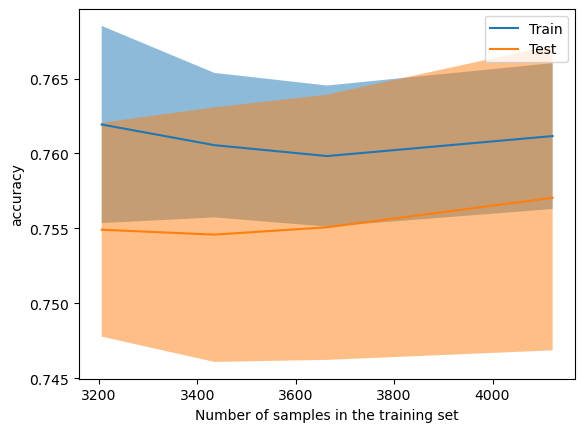

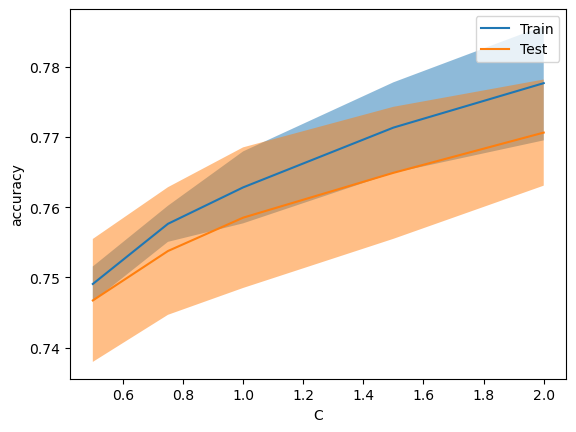

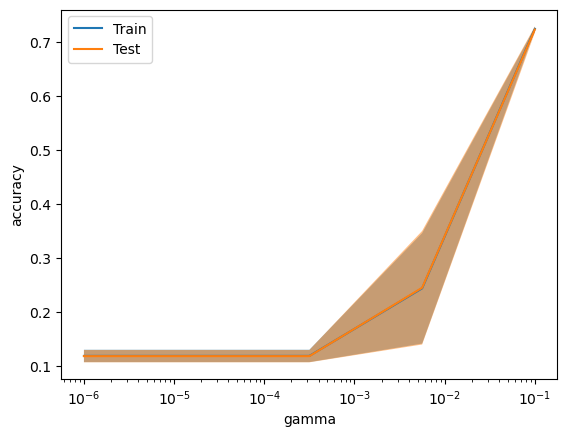

In [50]:
model_name = 'support vector machine'

print(f'Working on: {model_name}')

LCtrain_sizes = model_nf[model_name]['LCtrain_sizesnf']
LCtrain_scores = model_nf[model_name]['LCtrain_scoresnf']
LCtest_scores = model_nf[model_name]['LCtest_scoresnf']

VCtrain_scores1 = model_nf[model_name]['VCtrain_scores1nf']
VCtest_scores1 = model_nf[model_name]['VCtest_scores1nf']

VCtrain_scores2 = model_nf[model_name]['VCtrain_scores2nf']
VCtest_scores2 = model_nf[model_name]['VCtest_scores2nf']

param1_name = hyper_nf[model_name]['param1_name']
param1_range = hyper_nf[model_name]['param1_range']

param2_name = hyper_nf[model_name]['param2_name']
param2_range = hyper_nf[model_name]['param2_range']    

LCdisplay = LearningCurveDisplay(train_sizes=LCtrain_sizes,
                                train_scores=LCtrain_scores,
                                test_scores=LCtest_scores,
                                score_name="accuracy")

VCdisplay1 = ValidationCurveDisplay(param_name=param1_name,
                                    param_range=param1_range,
                                    train_scores=VCtrain_scores1,
                                    test_scores=VCtest_scores1,
                                    score_name="accuracy")

VCdisplay2 = ValidationCurveDisplay(param_name=param2_name,
                                    param_range=param2_range,
                                    train_scores=VCtrain_scores2,
                                    test_scores=VCtest_scores2,
                                    score_name="accuracy")
print(f'LC ({model_name})')
LCdisplay.plot()

print(f'VC: Hyper 1 ({param1_name})')    
VCdisplay1.plot()

print(f'VC: Hyper 2 ({param2_name})\n')
VCdisplay2.plot()

plt.show()

$$
\textbf{MLP}\\
\textbf{MLP}\\
\textbf{MLP}
$$

In [51]:
model_name = 'mlp'

print(f'Working on: {model_name}')

estimator = model_nf[model_name]['model']

VCparam_name1nf = hyper_nf[model_name]['param1_name']
VCparam_range1nf = hyper_nf[model_name]['param1_range']
VCparam_name2nf = hyper_nf[model_name]['param2_name']
VCparam_range2nf = hyper_nf[model_name]['param2_range']

# learning curve
print(f'Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)')
fittedLCnf = learning_curve(estimator=estimator,
                                X=X_train_scaled_nf,
                                y=y_train_nf,
                                train_sizes=[0.7, 0.75, 0.80, 0.90],
                                cv=4,
                                scoring='accuracy',
                                n_jobs=-1,
                                random_state=123,
                                return_times=True)

# validation curves
print(f'Fitting VC: Hyper 1 ({VCparam_name1nf}, {VCparam_range1nf})')
fittedVC_param1nf = validation_curve(estimator=estimator,
                                    X=X_train_scaled_nf,
                                    y=y_train_nf,
                                    param_name=VCparam_name1nf,
                                    param_range=VCparam_range1nf,
                                    cv=4,
                                    scoring='accuracy',
                                    n_jobs=-1,)

print(f'Fitting VC: Hyper 2 ({VCparam_name2nf}, {VCparam_range2nf})\n')
fittedVC_param2nf = validation_curve(estimator=estimator,
                                    X=X_train_scaled_nf,
                                    y=y_train_nf,
                                    param_name=VCparam_name2nf,
                                    param_range=VCparam_range2nf,
                                    cv=4,
                                    scoring='accuracy',
                                    n_jobs=-1,)

LCtrain_sizesnf, LCtrain_scoresnf, LCtest_scoresnf, fit_times, score_times = fittedLCnf
VCtrain_scores1nf, VCtest_scores1nf = fittedVC_param1nf
VCtrain_scores2nf, VCtest_scores2nf = fittedVC_param2nf

# learning curve to dict
model_nf[model_name]['LCtrain_sizesnf'] = LCtrain_sizesnf
model_nf[model_name]['LCtrain_scoresnf'] = LCtrain_scoresnf
model_nf[model_name]['LCtest_scoresnf'] = LCtest_scoresnf

# param1 vc to dict
model_nf[model_name]['VCtrain_scores1nf'] = VCtrain_scores1nf
model_nf[model_name]['VCtest_scores1nf'] = VCtest_scores1nf

# param2 vc to dict
model_nf[model_name]['VCtrain_scores2nf'] = VCtrain_scores2nf
model_nf[model_name]['VCtest_scores2nf'] = VCtest_scores2nf

Working on: mlp
Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)
Fitting VC: Hyper 1 (batch_size, [25, 50, 75, 100, 125])
Fitting VC: Hyper 2 (hidden_layer_sizes, [125, 150, 175, 200, 225, 230])



Working on: mlp
LC (mlp)
VC: Hyper 1 (batch_size)
VC: Hyper 2 (hidden_layer_sizes)



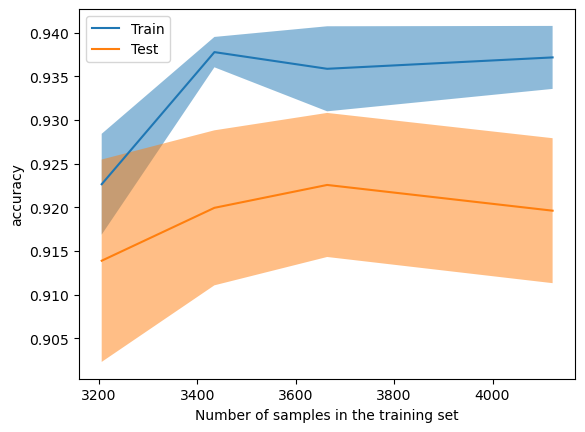

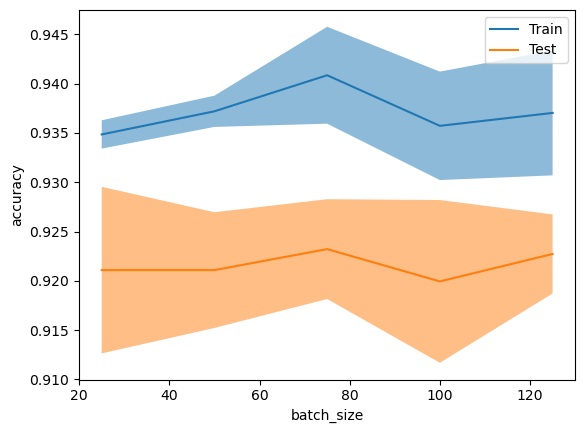

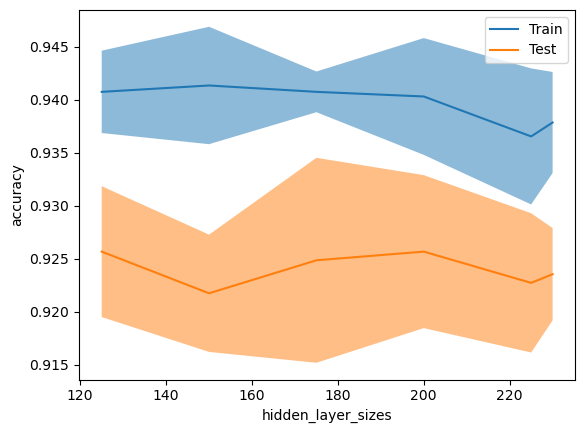

In [52]:
model_name = 'mlp'

print(f'Working on: {model_name}')

LCtrain_sizes = model_nf[model_name]['LCtrain_sizesnf']
LCtrain_scores = model_nf[model_name]['LCtrain_scoresnf']
LCtest_scores = model_nf[model_name]['LCtest_scoresnf']

VCtrain_scores1 = model_nf[model_name]['VCtrain_scores1nf']
VCtest_scores1 = model_nf[model_name]['VCtest_scores1nf']

VCtrain_scores2 = model_nf[model_name]['VCtrain_scores2nf']
VCtest_scores2 = model_nf[model_name]['VCtest_scores2nf']

param1_name = hyper_nf[model_name]['param1_name']
param1_range = hyper_nf[model_name]['param1_range']

param2_name = hyper_nf[model_name]['param2_name']
param2_range = hyper_nf[model_name]['param2_range']    

LCdisplay = LearningCurveDisplay(train_sizes=LCtrain_sizes,
                                train_scores=LCtrain_scores,
                                test_scores=LCtest_scores,
                                score_name="accuracy")

VCdisplay1 = ValidationCurveDisplay(param_name=param1_name,
                                    param_range=param1_range,
                                    train_scores=VCtrain_scores1,
                                    test_scores=VCtest_scores1,
                                    score_name="accuracy")

VCdisplay2 = ValidationCurveDisplay(param_name=param2_name,
                                    param_range=param2_range,
                                    train_scores=VCtrain_scores2,
                                    test_scores=VCtest_scores2,
                                    score_name="accuracy")
print(f'LC ({model_name})')
LCdisplay.plot()

print(f'VC: Hyper 1 ({param1_name})')    
VCdisplay1.plot()

print(f'VC: Hyper 2 ({param2_name})\n')
VCdisplay2.plot()

plt.show()


$$
\textbf{TESTING END}\\
\textbf{TESTING END}\\
\textbf{TESTING END}
$$

#### Final Model: Nutrition Facts